In [1]:
from comet_ml import Experiment, Optimizer

ModuleNotFoundError: No module named 'comet_ml'

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from collections import defaultdict
from tqdm import trange
import torch
import seaborn as sns
import os
import matplotlib.pyplot as plt
from io import BytesIO
import base64
import time
import datetime

plt.style.use("seaborn")
torch.set_default_dtype(torch.float32)

In [3]:
import node

In [4]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

In [5]:
from tabular_hypernet import HypernetworkPCA, TrainingModes, Hypernetwork
from tabular_hypernet.modules import SimpleNetwork
from tabular_hypernet.training_utils import train_slow_step, train_model, train_carthesian
from tabular_hypernet.interfaces import HypernetworkSklearnInterface, SimpleSklearnInterface
from ipynb.fs.defs.MNIST_benchmark import test_model

In [6]:
import pyhopper

In [7]:
from loguru import logger

logger.add("log.txt", format='{time:YYYY-MM-DD HH:mm:ss.SSS} | {message}')

1

In [8]:
DEVICE = 'cuda:1'

## Load data

In [9]:
data = pd.read_csv("../data/Blastchar/churn.csv")

In [10]:
processed_data = data.copy()
del processed_data["customerID"]
processed_data = processed_data[processed_data['TotalCharges'] != " "]
processed_data['TotalCharges'] = pd.to_numeric(processed_data['TotalCharges'])

y_label_enc = LabelEncoder()
y = y_label_enc.fit_transform(processed_data["Churn"].values)
del processed_data["Churn"]

### Preprocess features

In [11]:
label_encoders = {}
for col in processed_data.columns:
    if processed_data[col].dtype == 'object':
        encoder = LabelEncoder()
        processed_data[col] = encoder.fit_transform(processed_data[col].values)
        label_encoders[col] = encoder
        
X = processed_data.values
print(X.shape)

(7032, 19)


In [12]:
X.shape

(7032, 19)

### Split it into train and test set

## Preprocess

In [13]:
np.random.seed(42)

def prepare_data(X, y, size=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=size, stratify=y)
    # X_train, y_train = imblearn.over_sampling.RandomOverSampler(random_state=42).fit_resample(X_train, y_train)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    X_train, X_test, y_train, y_test = [torch.from_numpy(x) for x in [X_train, X_test, y_train, y_test]]
    
    return X_train, X_test, y_train, y_test

In [14]:
X_train, X_test, y_train, y_test = prepare_data(X, y, size=100)

## Benchmark

In [15]:
criterion = torch.nn.CrossEntropyLoss()

In [16]:
def _summarize_results(y_pred, y_score, y_test, labels):
    results = []
    for idx, label in enumerate(labels):
        y_pred_filt = y_pred[y_test==idx]
        y_test_filt = y_test[y_test==idx]
        acc = (y_pred_filt==y_test_filt.numpy()).sum()/len(y_test_filt)*100
        results.append({
            "Class": label,
            "Metric": acc
        })
        
    acc = (y_pred==y_test.numpy()).sum()/len(y_test)*100    
    results.append({
        "Class": "Total",
        "Metric": acc
    })
    try:
        results.append({
            "Class": "F1 score",
            "Metric": f1_score(y_test, torch.from_numpy(y_pred)).item()*100
        })
        results.append({
            "Class": "ROC score",
            "Metric": roc_auc_score(y_test, torch.from_numpy(y_score[:, 1])).item()*100
        })
        results.append({
            "Class": "Precision",
            "Metric": precision_score(y_test, torch.from_numpy(y_pred)).item()*100
        })
        results.append({
            "Class": "Recall",
            "Metric": recall_score(y_test, torch.from_numpy(y_pred)).item()*100
        })
    except ValueError:
        pass
    results.append({
        "Class": "Loss",
        "Metric": criterion(torch.from_numpy(y_score), y_test).item()*100
    })
    return results

def test_model(model_fn, data, train_size, label_encoder=None, iters=10, as_numpy=False):
    if label_encoder is not None:
        labels = label_encoder.classes_
    else:
        labels = sorted(pd.unique(data[1]))
    
    results = []

    for i in range(iters):
        X_train, X_test, y_train, y_test = prepare_data(*data, train_size)
        
        model = model_fn()

        if as_numpy:
            model.fit(X_train.numpy(), y_train.numpy());
        else:
            model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        y_score = model.predict_proba(X_test)
        results.extend(_summarize_results(y_pred, y_score, y_test, labels))

    dframe = pd.DataFrame.from_dict(results)
    sns.violinplot(data=dframe[dframe["Class"]!="Loss"], y="Class", x="Metric", orient='h')
    return dframe

### XGBoost

In [17]:
from xgboost import XGBClassifier

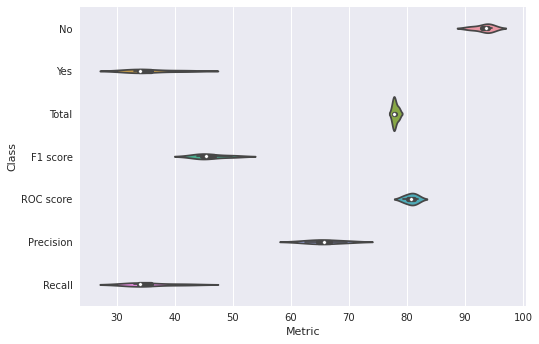

In [18]:
def get_xgboost(params=dict()):
    def _inner():
        random_seed = np.random.randint(1024)
        return XGBClassifier(
            verbosity=0,
            **params,
            use_label_encoder=False)
    return _inner

xgb_dframe = test_model(get_xgboost({
                            "lambda": 0.7,
                            "alpha": 1e-3,
                            "colsample_bytree": 0.38,
                            "subsample": 0.65,
                            "learning_rate": 0.004,
                            "max_depth": 5
                        }),
                        (X, y),
                        100,
                        label_encoder=y_label_enc, iters=4)

In [19]:
res = xgb_dframe[xgb_dframe["Class"]=="ROC score"].reset_index(drop=True)["Metric"]
print(f"{100}: {res.mean():.2f} ~ {res.std():.2f} (max: {res.max():.2f})")

100: 80.67 ~ 1.03 (max: 81.83)


  0%|          | [00:00<?]

Search is scheduled for 01:00:00 (h:m:s)


/tmp/ipykernel_1611370/32698201.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_1611370/32698201.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]
/tmp/ipykernel_1611370/32698201.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params)

==================== Summary ===================
Mode              : Best f : Steps : Time       
----------------  : ----   : ----  : ----       
Initial solution  : 84.18  : 1     : 721 ms     
Random seeding    : 85     : 1k    : 29:57 (m:s)
Local sampling    : 85.08  : 777   : 29:55 (m:s)
Duplicates        : -      : 28    : -          
----------------  : ----   : ----  : ----       
Total             : 85.08  : 1k    : 59:59 (m:s)


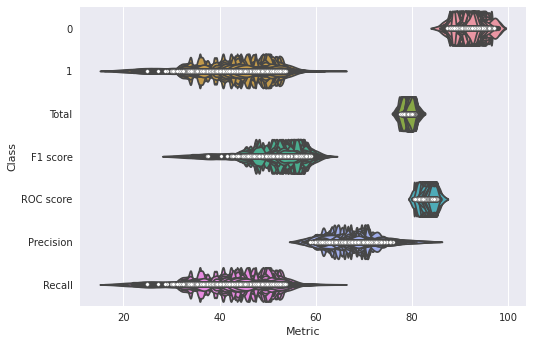

In [27]:
def objective(params):
    nn_results = test_model(get_xgboost(params),
                    (X, y),
                    3000,
                    None, 4)
    with open("xgboost_params.txt", "a") as f:
        f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]) + "\n")
    return nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]

from pyhopper.callbacks import History
search = pyhopper.Search(
    {
        "lambda": pyhopper.float(1e-3, 1e1, log=True),
        "alpha": pyhopper.float(1e-3, 1e-1, log=True),
        "colsample_bytree": pyhopper.float(0.3, 1.0),
        "subsample": pyhopper.float(0.4, 1.0),
        "learning_rate": pyhopper.float(0.001, 0.1, log=True),
        "max_depth": pyhopper.choice([3,5,7,9,11,13,15,17,20])
    }
)

# An run the optimization for 60 minutes
best_params = search.run(objective, "maximize", "1h", n_jobs=1, seeding_ratio=0.5)

In [ ]:
best_params

{'lambda': 0.7001889023735167,
 'alpha': 0.0010371890766955596,
 'colsample_bytree': 0.3864363599523588,
 'subsample': 0.6524499069919327,
 'learning_rate': 0.004048680262992145,
 'max_depth': 5}

### Neural network

In [34]:
def simple_network_fn(epochs):
    def _inner():
#         net = SimpleNetwork(X_train.shape[1], outputs=2).to(DEVICE)
        net = torch.nn.Sequential(
            torch.nn.Dropout(1-5/19),
            torch.nn.Linear(X_train.shape[1], 100),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(100, 2)
        ).to(DEVICE)
        return SimpleSklearnInterface(net, device=DEVICE, epochs=epochs, batch_size=32)
    return _inner

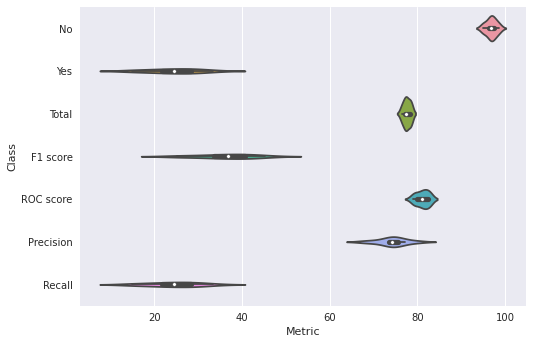

In [35]:
simple_nn_results = test_model(simple_network_fn(50),
                    (X, y),
                    3000,
                    label_encoder=y_label_enc, iters=10)

In [38]:
res = simple_nn_results[simple_nn_results["Class"]=="ROC score"].reset_index(drop=True)["Metric"]
print(f"{3000}: {res.mean():.2f} ~ {res.std():.2f}, (max: {res.max():.2f})")

3000: 81.13 ~ 1.41, (max: 82.74)


### NODE

In [39]:
from qhoptim.pyt import QHAdam

In [40]:
def node_fn(layer_dims):
    def _inner():
        network = torch.nn.Sequential(
            node.DenseBlock(X_train.shape[1], layer_dims, num_layers=1, tree_dim=2, depth=6, flatten_output=False,
                           choice_function=node.entmax15, bin_function=node.entmoid15),
            node.Lambda(lambda x: x.mean(dim=1))
        )
        
        with torch.no_grad():
            res = network(torch.as_tensor(X_train[:1000], device='cpu').to(torch.float32))
        
        network = network.to(DEVICE)
        network.device=DEVICE
            
        optimizer_params = { 'nus':(0.7, 1.0), 'betas':(0.95, 0.998) }
        optim = QHAdam(network.parameters(), **optimizer_params)
            
        network = SimpleSklearnInterface(network, device=DEVICE, epochs=150, batch_size=32)
        network.optimizer = optim
        return network
    return _inner

In [41]:
%%capture --no-stdout

node_results = test_model(node_fn(128),
                    (X, y),
                    3000,
                    label_encoder=y_label_enc, iters=10)

In [42]:
res = node_results[node_results["Class"]=="ROC score"].reset_index(drop=True)["Metric"]
print(f"{3000}: {res.mean():.2f} ~ {res.std():.2f}, (max: {res.max():.2f})")

3000: 83.60 ~ 0.49, (max: 84.14)


### HypernetworkPCA

In [18]:
def network_pca_fn(epochs=150, masks_no=100, mask_size=100, target_size=100):
    def _inner():
        hypernet = HypernetworkPCA(
                        target_architecture=[(mask_size, target_size), (target_size, 2)], 
                        test_nodes=masks_no,
                        architecture=torch.nn.Sequential(torch.nn.Linear(12, 32), 
                            torch.nn.ReLU(),
                            torch.nn.Linear(32, 128),
                            torch.nn.ReLU(),
                            torch.nn.Dropout(),
                            torch.nn.Linear(128, 128),
                            torch.nn.ReLU(),
                        ),
                        mode=TrainingModes.CARTHESIAN,
                        input_size=19
                    ).to(DEVICE)    
        hypernet = hypernet.train()

        network = HypernetworkSklearnInterface(hypernet, device=DEVICE, epochs=epochs, batch_size=64)
        return network
    return _inner

In [19]:
def figure_to_html():
    tmpfile = BytesIO()
    plt.gcf().savefig(tmpfile, format='png')
    encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')

    html = '<img src=\'data:image/png;base64,{}\'>'.format(encoded)
    return html

#### Hyperparameter optimizations

  0%|          | [00:00<?]

Search is scheduled for 02:00:00 (h:m:s)
Training...
torch.Size([1, 128])
19







  0%|                                                                                                                                        | 0/100 [00:00<?, ?it/s]




  1%|█▎                                                                                                                              | 1/100 [00:01<02:57,  1.79s/it]




  2%|██▌                                                                                                                             | 2/100 [00:03<02:55,  1.79s/it]




  3%|███▊                                                                                                                            | 3/100 [00:05<02:55,  1.80s/it]




  4%|█████                                                                                                                           | 4/100 [00:07<03:00,  1.88s/it]




  5%|██████▍                                                                                                                         | 5/100 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                        | 0/100 [00:00<?, ?it/s]




  1%|█▎                                                                                                                              | 1/100 [00:01<02:55,  1.77s/it]




  2%|██▌                                                                                                                             | 2/100 [00:03<02:51,  1.75s/it]




  3%|███▊                                                                                                                            | 3/100 [00:05<02:52,  1.78s/it]




  4%|█████                                                                                                                           | 4/100 [00:07<02:51,  1.79s/it]




  5%|██████▍                                                                                                                         | 5/100 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                        | 0/100 [00:00<?, ?it/s]




  1%|█▎                                                                                                                              | 1/100 [00:00<00:52,  1.88it/s]




  2%|██▌                                                                                                                             | 2/100 [00:01<00:50,  1.95it/s]




  3%|███▊                                                                                                                            | 3/100 [00:01<00:51,  1.90it/s]




  4%|█████                                                                                                                           | 4/100 [00:02<00:49,  1.96it/s]




  5%|██████▍                                                                                                                         | 5/100 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                        | 0/100 [00:00<?, ?it/s]




  1%|█▎                                                                                                                              | 1/100 [00:00<00:52,  1.89it/s]




  2%|██▌                                                                                                                             | 2/100 [00:01<00:49,  1.99it/s]




  3%|███▊                                                                                                                            | 3/100 [00:01<00:47,  2.03it/s]




  4%|█████                                                                                                                           | 4/100 [00:01<00:46,  2.05it/s]




  5%|██████▍                                                                                                                         | 5/100 [00:

Training...
torch.Size([1, 128])
19







  0%|                                                                                                                                        | 0/140 [00:00<?, ?it/s]




  1%|▉                                                                                                                               | 1/140 [00:00<01:30,  1.53it/s]




  1%|█▊                                                                                                                              | 2/140 [00:01<01:27,  1.57it/s]




  2%|██▋                                                                                                                             | 3/140 [00:01<01:26,  1.58it/s]




  3%|███▋                                                                                                                            | 4/140 [00:02<01:26,  1.57it/s]




  4%|████▌                                                                                                                           | 5/140 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                        | 0/140 [00:00<?, ?it/s]




  1%|▉                                                                                                                               | 1/140 [00:00<01:30,  1.53it/s]




  1%|█▊                                                                                                                              | 2/140 [00:01<01:28,  1.56it/s]




  2%|██▋                                                                                                                             | 3/140 [00:01<01:27,  1.57it/s]




  3%|███▋                                                                                                                            | 4/140 [00:02<01:26,  1.57it/s]




  4%|████▌                                                                                                                           | 5/140 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                        | 0/140 [00:00<?, ?it/s]




  1%|▉                                                                                                                               | 1/140 [00:02<05:48,  2.51s/it]




  1%|█▊                                                                                                                              | 2/140 [00:05<05:47,  2.52s/it]




  2%|██▋                                                                                                                             | 3/140 [00:07<05:45,  2.52s/it]




  3%|███▋                                                                                                                            | 4/140 [00:10<05:39,  2.50s/it]




  4%|████▌                                                                                                                           | 5/140 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                        | 0/140 [00:00<?, ?it/s]




  1%|▉                                                                                                                               | 1/140 [00:00<01:31,  1.51it/s]




  1%|█▊                                                                                                                              | 2/140 [00:01<01:29,  1.55it/s]




  2%|██▋                                                                                                                             | 3/140 [00:02<01:33,  1.47it/s]




  3%|███▋                                                                                                                            | 4/140 [00:02<01:30,  1.51it/s]




  4%|████▌                                                                                                                           | 5/140 [00:

Training...
torch.Size([1, 128])
19







  0%|                                                                                                                                         | 0/50 [00:00<?, ?it/s]




  2%|██▌                                                                                                                              | 1/50 [00:00<00:24,  2.03it/s]




  4%|█████▏                                                                                                                           | 2/50 [00:00<00:23,  2.07it/s]




  6%|███████▋                                                                                                                         | 3/50 [00:01<00:22,  2.08it/s]




  8%|██████████▎                                                                                                                      | 4/50 [00:01<00:22,  2.08it/s]




 10%|████████████▉                                                                                                                    | 5/50 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                         | 0/50 [00:00<?, ?it/s]




  2%|██▌                                                                                                                              | 1/50 [00:00<00:27,  1.77it/s]




  4%|█████▏                                                                                                                           | 2/50 [00:01<00:24,  1.92it/s]




  6%|███████▋                                                                                                                         | 3/50 [00:01<00:25,  1.88it/s]




  8%|██████████▎                                                                                                                      | 4/50 [00:02<00:24,  1.86it/s]




 10%|████████████▉                                                                                                                    | 5/50 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                         | 0/50 [00:00<?, ?it/s]




  2%|██▌                                                                                                                              | 1/50 [00:00<00:24,  2.01it/s]




  4%|█████▏                                                                                                                           | 2/50 [00:00<00:23,  2.06it/s]




  6%|███████▋                                                                                                                         | 3/50 [00:01<00:22,  2.07it/s]




  8%|██████████▎                                                                                                                      | 4/50 [00:01<00:22,  2.09it/s]




 10%|████████████▉                                                                                                                    | 5/50 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                         | 0/50 [00:00<?, ?it/s]




  2%|██▌                                                                                                                              | 1/50 [00:00<00:25,  1.95it/s]




  4%|█████▏                                                                                                                           | 2/50 [00:01<00:24,  1.97it/s]




  6%|███████▋                                                                                                                         | 3/50 [00:01<00:23,  1.98it/s]




  8%|██████████▎                                                                                                                      | 4/50 [00:02<00:23,  1.98it/s]




 10%|████████████▉                                                                                                                    | 5/50 [00:

Training...
torch.Size([1, 128])
19







  0%|                                                                                                                                         | 0/70 [00:00<?, ?it/s]




  1%|█▊                                                                                                                               | 1/70 [00:00<00:23,  2.92it/s]




  3%|███▋                                                                                                                             | 2/70 [00:00<00:22,  2.96it/s]




  4%|█████▌                                                                                                                           | 3/70 [00:01<00:22,  2.98it/s]




  6%|███████▎                                                                                                                         | 4/70 [00:01<00:22,  2.99it/s]




  7%|█████████▏                                                                                                                       | 5/70 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                         | 0/70 [00:00<?, ?it/s]




  1%|█▊                                                                                                                               | 1/70 [00:00<00:23,  2.91it/s]




  3%|███▋                                                                                                                             | 2/70 [00:00<00:22,  2.99it/s]




  4%|█████▌                                                                                                                           | 3/70 [00:01<00:22,  3.01it/s]




  6%|███████▎                                                                                                                         | 4/70 [00:01<00:21,  3.01it/s]




  7%|█████████▏                                                                                                                       | 5/70 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                         | 0/70 [00:00<?, ?it/s]




  1%|█▊                                                                                                                               | 1/70 [00:01<01:19,  1.15s/it]




  3%|███▋                                                                                                                             | 2/70 [00:02<01:18,  1.15s/it]




  4%|█████▌                                                                                                                           | 3/70 [00:03<01:21,  1.22s/it]




  6%|███████▎                                                                                                                         | 4/70 [00:04<01:20,  1.21s/it]




  7%|█████████▏                                                                                                                       | 5/70 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                         | 0/70 [00:00<?, ?it/s]




  1%|█▊                                                                                                                               | 1/70 [00:01<01:19,  1.15s/it]




  3%|███▋                                                                                                                             | 2/70 [00:02<01:20,  1.18s/it]




  4%|█████▌                                                                                                                           | 3/70 [00:03<01:19,  1.19s/it]




  6%|███████▎                                                                                                                         | 4/70 [00:04<01:17,  1.17s/it]




  7%|█████████▏                                                                                                                       | 5/70 [00:

Training...
torch.Size([1, 128])
19







  0%|                                                                                                                                         | 0/80 [00:00<?, ?it/s]




  1%|█▌                                                                                                                               | 1/80 [00:02<03:01,  2.30s/it]




  2%|███▏                                                                                                                             | 2/80 [00:03<02:17,  1.76s/it]




  4%|████▊                                                                                                                            | 3/80 [00:05<02:04,  1.62s/it]




  5%|██████▍                                                                                                                          | 4/80 [00:06<02:00,  1.59s/it]




  6%|████████                                                                                                                         | 5/80 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                         | 0/80 [00:00<?, ?it/s]




  1%|█▌                                                                                                                               | 1/80 [00:00<00:32,  2.47it/s]




  2%|███▏                                                                                                                             | 2/80 [00:00<00:30,  2.56it/s]




  4%|████▊                                                                                                                            | 3/80 [00:01<00:29,  2.57it/s]




  5%|██████▍                                                                                                                          | 4/80 [00:01<00:29,  2.57it/s]




  6%|████████                                                                                                                         | 5/80 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                         | 0/80 [00:00<?, ?it/s]




  1%|█▌                                                                                                                               | 1/80 [00:00<00:31,  2.52it/s]




  2%|███▏                                                                                                                             | 2/80 [00:00<00:30,  2.57it/s]




  4%|████▊                                                                                                                            | 3/80 [00:01<00:29,  2.59it/s]




  5%|██████▍                                                                                                                          | 4/80 [00:01<00:29,  2.61it/s]




  6%|████████                                                                                                                         | 5/80 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                         | 0/80 [00:00<?, ?it/s]




  1%|█▌                                                                                                                               | 1/80 [00:00<00:31,  2.54it/s]




  2%|███▏                                                                                                                             | 2/80 [00:00<00:30,  2.59it/s]




  4%|████▊                                                                                                                            | 3/80 [00:01<00:29,  2.61it/s]




  5%|██████▍                                                                                                                          | 4/80 [00:01<00:29,  2.61it/s]




  6%|████████                                                                                                                         | 5/80 [00:

Training...
torch.Size([1, 128])
19







  0%|                                                                                                                                        | 0/100 [00:00<?, ?it/s]




  1%|█▎                                                                                                                              | 1/100 [00:00<00:50,  1.96it/s]




  2%|██▌                                                                                                                             | 2/100 [00:00<00:48,  2.04it/s]




  3%|███▊                                                                                                                            | 3/100 [00:01<00:47,  2.04it/s]




  4%|█████                                                                                                                           | 4/100 [00:01<00:46,  2.05it/s]




  5%|██████▍                                                                                                                         | 5/100 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                        | 0/100 [00:00<?, ?it/s]




  1%|█▎                                                                                                                              | 1/100 [00:00<00:49,  2.01it/s]




  2%|██▌                                                                                                                             | 2/100 [00:00<00:47,  2.05it/s]




  3%|███▊                                                                                                                            | 3/100 [00:01<00:47,  2.06it/s]




  4%|█████                                                                                                                           | 4/100 [00:01<00:46,  2.07it/s]




  5%|██████▍                                                                                                                         | 5/100 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                        | 0/100 [00:00<?, ?it/s]




  1%|█▎                                                                                                                              | 1/100 [00:00<00:50,  1.97it/s]




  2%|██▌                                                                                                                             | 2/100 [00:00<00:48,  2.03it/s]




  3%|███▊                                                                                                                            | 3/100 [00:01<00:47,  2.05it/s]




  4%|█████                                                                                                                           | 4/100 [00:01<00:46,  2.05it/s]




  5%|██████▍                                                                                                                         | 5/100 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                        | 0/100 [00:00<?, ?it/s]




  1%|█▎                                                                                                                              | 1/100 [00:00<00:58,  1.70it/s]




  2%|██▌                                                                                                                             | 2/100 [00:01<00:52,  1.85it/s]




  3%|███▊                                                                                                                            | 3/100 [00:01<00:50,  1.93it/s]




  4%|█████                                                                                                                           | 4/100 [00:02<00:48,  1.97it/s]




  5%|██████▍                                                                                                                         | 5/100 [00:

Training...
torch.Size([1, 128])
19







  0%|                                                                                                                                        | 0/120 [00:00<?, ?it/s]




  1%|█                                                                                                                               | 1/120 [00:01<02:50,  1.43s/it]




  2%|██▏                                                                                                                             | 2/120 [00:02<02:45,  1.40s/it]




  2%|███▏                                                                                                                            | 3/120 [00:04<02:46,  1.42s/it]




  3%|████▎                                                                                                                           | 4/120 [00:05<02:49,  1.46s/it]




  4%|█████▎                                                                                                                          | 5/120 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                        | 0/120 [00:00<?, ?it/s]




  1%|█                                                                                                                               | 1/120 [00:00<00:47,  2.51it/s]




  2%|██▏                                                                                                                             | 2/120 [00:00<00:45,  2.57it/s]




  2%|███▏                                                                                                                            | 3/120 [00:01<00:45,  2.57it/s]




  3%|████▎                                                                                                                           | 4/120 [00:01<00:44,  2.59it/s]




  4%|█████▎                                                                                                                          | 5/120 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                        | 0/120 [00:00<?, ?it/s]




  1%|█                                                                                                                               | 1/120 [00:00<00:50,  2.35it/s]




  2%|██▏                                                                                                                             | 2/120 [00:00<00:47,  2.50it/s]




  2%|███▏                                                                                                                            | 3/120 [00:01<00:45,  2.55it/s]




  3%|████▎                                                                                                                           | 4/120 [00:01<00:44,  2.58it/s]




  4%|█████▎                                                                                                                          | 5/120 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                        | 0/120 [00:00<?, ?it/s]




  1%|█                                                                                                                               | 1/120 [00:00<00:48,  2.46it/s]




  2%|██▏                                                                                                                             | 2/120 [00:00<00:46,  2.54it/s]




  2%|███▏                                                                                                                            | 3/120 [00:01<00:45,  2.58it/s]




  3%|████▎                                                                                                                           | 4/120 [00:01<00:46,  2.52it/s]




  4%|█████▎                                                                                                                          | 5/120 [00:

Training...
torch.Size([1, 128])
19







  0%|                                                                                                                                        | 0/130 [00:00<?, ?it/s]




  1%|▉                                                                                                                               | 1/130 [00:00<01:25,  1.51it/s]




  2%|█▉                                                                                                                              | 2/130 [00:01<01:22,  1.55it/s]




  2%|██▉                                                                                                                             | 3/130 [00:01<01:21,  1.55it/s]




  3%|███▉                                                                                                                            | 4/130 [00:02<01:21,  1.55it/s]




  4%|████▉                                                                                                                           | 5/130 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                        | 0/130 [00:00<?, ?it/s]




  1%|▉                                                                                                                               | 1/130 [00:00<01:24,  1.52it/s]




  2%|█▉                                                                                                                              | 2/130 [00:01<01:22,  1.55it/s]




  2%|██▉                                                                                                                             | 3/130 [00:01<01:21,  1.56it/s]




  3%|███▉                                                                                                                            | 4/130 [00:02<01:20,  1.57it/s]




  4%|████▉                                                                                                                           | 5/130 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                        | 0/130 [00:00<?, ?it/s]




  1%|▉                                                                                                                               | 1/130 [00:02<05:22,  2.50s/it]




  2%|█▉                                                                                                                              | 2/130 [00:04<04:50,  2.27s/it]




  2%|██▉                                                                                                                             | 3/130 [00:06<04:33,  2.15s/it]




  3%|███▉                                                                                                                            | 4/130 [00:08<04:37,  2.20s/it]




  4%|████▉                                                                                                                           | 5/130 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                        | 0/130 [00:00<?, ?it/s]




  1%|▉                                                                                                                               | 1/130 [00:00<01:26,  1.49it/s]




  2%|█▉                                                                                                                              | 2/130 [00:01<01:23,  1.54it/s]




  2%|██▉                                                                                                                             | 3/130 [00:01<01:21,  1.55it/s]




  3%|███▉                                                                                                                            | 4/130 [00:02<01:21,  1.55it/s]




  4%|████▉                                                                                                                           | 5/130 [00:

Training...
torch.Size([1, 128])
19







  0%|                                                                                                                                         | 0/90 [00:00<?, ?it/s]




  1%|█▍                                                                                                                               | 1/90 [00:00<00:32,  2.71it/s]




  2%|██▊                                                                                                                              | 2/90 [00:00<00:32,  2.72it/s]




  3%|████▎                                                                                                                            | 3/90 [00:01<00:30,  2.85it/s]




  4%|█████▋                                                                                                                           | 4/90 [00:01<00:29,  2.91it/s]




  6%|███████▏                                                                                                                         | 5/90 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                         | 0/90 [00:00<?, ?it/s]




  1%|█▍                                                                                                                               | 1/90 [00:00<00:35,  2.54it/s]




  2%|██▊                                                                                                                              | 2/90 [00:00<00:32,  2.73it/s]




  3%|████▎                                                                                                                            | 3/90 [00:01<00:31,  2.79it/s]




  4%|█████▋                                                                                                                           | 4/90 [00:01<00:30,  2.79it/s]




  6%|███████▏                                                                                                                         | 5/90 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                         | 0/90 [00:00<?, ?it/s]




  1%|█▍                                                                                                                               | 1/90 [00:00<00:31,  2.81it/s]




  2%|██▊                                                                                                                              | 2/90 [00:00<00:30,  2.93it/s]




  3%|████▎                                                                                                                            | 3/90 [00:01<00:29,  2.95it/s]




  4%|█████▋                                                                                                                           | 4/90 [00:01<00:28,  2.99it/s]




  6%|███████▏                                                                                                                         | 5/90 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                         | 0/90 [00:00<?, ?it/s]




  1%|█▍                                                                                                                               | 1/90 [00:00<00:30,  2.91it/s]




  2%|██▊                                                                                                                              | 2/90 [00:00<00:29,  2.97it/s]




  3%|████▎                                                                                                                            | 3/90 [00:01<00:30,  2.86it/s]




  4%|█████▋                                                                                                                           | 4/90 [00:01<00:29,  2.92it/s]




  6%|███████▏                                                                                                                         | 5/90 [00:

Training...
torch.Size([1, 128])
19







  0%|                                                                                                                                        | 0/110 [00:00<?, ?it/s]




  1%|█▏                                                                                                                              | 1/110 [00:00<01:12,  1.51it/s]




  2%|██▎                                                                                                                             | 2/110 [00:01<01:15,  1.42it/s]




  3%|███▍                                                                                                                            | 3/110 [00:02<01:12,  1.49it/s]




  4%|████▋                                                                                                                           | 4/110 [00:02<01:09,  1.52it/s]




  5%|█████▊                                                                                                                          | 5/110 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                        | 0/110 [00:00<?, ?it/s]




  1%|█▏                                                                                                                              | 1/110 [00:01<03:17,  1.82s/it]




  2%|██▎                                                                                                                             | 2/110 [00:04<03:54,  2.17s/it]




  3%|███▍                                                                                                                            | 3/110 [00:06<04:14,  2.38s/it]




  4%|████▋                                                                                                                           | 4/110 [00:09<04:30,  2.55s/it]




  5%|█████▊                                                                                                                          | 5/110 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                        | 0/110 [00:00<?, ?it/s]




  1%|█▏                                                                                                                              | 1/110 [00:00<01:11,  1.52it/s]




  2%|██▎                                                                                                                             | 2/110 [00:01<01:09,  1.54it/s]




  3%|███▍                                                                                                                            | 3/110 [00:01<01:10,  1.52it/s]




  4%|████▋                                                                                                                           | 4/110 [00:02<01:09,  1.53it/s]




  5%|█████▊                                                                                                                          | 5/110 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                        | 0/110 [00:00<?, ?it/s]




  1%|█▏                                                                                                                              | 1/110 [00:00<01:13,  1.48it/s]




  2%|██▎                                                                                                                             | 2/110 [00:01<01:10,  1.52it/s]




  3%|███▍                                                                                                                            | 3/110 [00:01<01:09,  1.54it/s]




  4%|████▋                                                                                                                           | 4/110 [00:02<01:08,  1.55it/s]




  5%|█████▊                                                                                                                          | 5/110 [00:

Training...
torch.Size([1, 128])
19







  0%|                                                                                                                                        | 0/130 [00:00<?, ?it/s]




  1%|▉                                                                                                                               | 1/130 [00:00<00:58,  2.22it/s]




  2%|█▉                                                                                                                              | 2/130 [00:00<00:52,  2.42it/s]




  2%|██▉                                                                                                                             | 3/130 [00:01<00:50,  2.50it/s]




  3%|███▉                                                                                                                            | 4/130 [00:01<00:49,  2.54it/s]




  4%|████▉                                                                                                                           | 5/130 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                        | 0/130 [00:00<?, ?it/s]




  1%|▉                                                                                                                               | 1/130 [00:00<00:52,  2.47it/s]




  2%|█▉                                                                                                                              | 2/130 [00:00<00:50,  2.53it/s]




  2%|██▉                                                                                                                             | 3/130 [00:01<00:49,  2.55it/s]




  3%|███▉                                                                                                                            | 4/130 [00:01<00:49,  2.55it/s]




  4%|████▉                                                                                                                           | 5/130 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                        | 0/130 [00:00<?, ?it/s]




  1%|▉                                                                                                                               | 1/130 [00:00<00:54,  2.38it/s]




  2%|█▉                                                                                                                              | 2/130 [00:00<00:51,  2.47it/s]




  2%|██▉                                                                                                                             | 3/130 [00:01<00:50,  2.49it/s]




  3%|███▉                                                                                                                            | 4/130 [00:01<00:50,  2.50it/s]




  4%|████▉                                                                                                                           | 5/130 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                        | 0/130 [00:00<?, ?it/s]




  1%|▉                                                                                                                               | 1/130 [00:01<02:53,  1.35s/it]




  2%|█▉                                                                                                                              | 2/130 [00:02<02:55,  1.37s/it]




  2%|██▉                                                                                                                             | 3/130 [00:04<02:54,  1.38s/it]




  3%|███▉                                                                                                                            | 4/130 [00:05<02:54,  1.39s/it]




  4%|████▉                                                                                                                           | 5/130 [00:

Training...
torch.Size([1, 128])
19







  0%|                                                                                                                                         | 0/70 [00:00<?, ?it/s]




  1%|█▊                                                                                                                               | 1/70 [00:00<00:24,  2.81it/s]




  3%|███▋                                                                                                                             | 2/70 [00:00<00:23,  2.93it/s]




  4%|█████▌                                                                                                                           | 3/70 [00:01<00:22,  2.96it/s]




  6%|███████▎                                                                                                                         | 4/70 [00:01<00:22,  2.98it/s]




  7%|█████████▏                                                                                                                       | 5/70 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                         | 0/70 [00:00<?, ?it/s]




  1%|█▊                                                                                                                               | 1/70 [00:00<00:23,  2.90it/s]




  3%|███▋                                                                                                                             | 2/70 [00:00<00:22,  2.96it/s]




  4%|█████▌                                                                                                                           | 3/70 [00:01<00:22,  2.99it/s]




  6%|███████▎                                                                                                                         | 4/70 [00:01<00:22,  3.00it/s]




  7%|█████████▏                                                                                                                       | 5/70 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                         | 0/70 [00:00<?, ?it/s]




  1%|█▊                                                                                                                               | 1/70 [00:00<00:24,  2.86it/s]




  3%|███▋                                                                                                                             | 2/70 [00:00<00:23,  2.92it/s]




  4%|█████▌                                                                                                                           | 3/70 [00:01<00:22,  2.96it/s]




  6%|███████▎                                                                                                                         | 4/70 [00:01<00:22,  2.94it/s]




  7%|█████████▏                                                                                                                       | 5/70 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                         | 0/70 [00:00<?, ?it/s]




  1%|█▊                                                                                                                               | 1/70 [00:00<00:24,  2.79it/s]




  3%|███▋                                                                                                                             | 2/70 [00:00<00:24,  2.77it/s]




  4%|█████▌                                                                                                                           | 3/70 [00:01<00:23,  2.88it/s]




  6%|███████▎                                                                                                                         | 4/70 [00:01<00:22,  2.92it/s]




  7%|█████████▏                                                                                                                       | 5/70 [00:

Training...
torch.Size([1, 128])
19







  0%|                                                                                                                                        | 0/100 [00:00<?, ?it/s]




  1%|█▎                                                                                                                              | 1/100 [00:00<00:38,  2.60it/s]




  2%|██▌                                                                                                                             | 2/100 [00:00<00:34,  2.83it/s]




  3%|███▊                                                                                                                            | 3/100 [00:01<00:33,  2.92it/s]




  4%|█████                                                                                                                           | 4/100 [00:01<00:32,  2.98it/s]




  5%|██████▍                                                                                                                         | 5/100 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                        | 0/100 [00:00<?, ?it/s]




  1%|█▎                                                                                                                              | 1/100 [00:00<00:38,  2.54it/s]




  2%|██▌                                                                                                                             | 2/100 [00:00<00:35,  2.75it/s]




  3%|███▊                                                                                                                            | 3/100 [00:01<00:34,  2.85it/s]




  4%|█████                                                                                                                           | 4/100 [00:01<00:33,  2.90it/s]




  5%|██████▍                                                                                                                         | 5/100 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                        | 0/100 [00:00<?, ?it/s]




  1%|█▎                                                                                                                              | 1/100 [00:00<00:35,  2.76it/s]




  2%|██▌                                                                                                                             | 2/100 [00:00<00:33,  2.90it/s]




  3%|███▊                                                                                                                            | 3/100 [00:01<00:32,  2.94it/s]




  4%|█████                                                                                                                           | 4/100 [00:01<00:32,  2.97it/s]




  5%|██████▍                                                                                                                         | 5/100 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                        | 0/100 [00:00<?, ?it/s]




  1%|█▎                                                                                                                              | 1/100 [00:00<00:35,  2.78it/s]




  2%|██▌                                                                                                                             | 2/100 [00:00<00:33,  2.88it/s]




  3%|███▊                                                                                                                            | 3/100 [00:01<00:33,  2.93it/s]




  4%|█████                                                                                                                           | 4/100 [00:01<00:32,  2.96it/s]




  5%|██████▍                                                                                                                         | 5/100 [00:

Training...
torch.Size([1, 128])
19







  0%|                                                                                                                                        | 0/100 [00:00<?, ?it/s]




  1%|█▎                                                                                                                              | 1/100 [00:00<00:30,  3.28it/s]




  2%|██▌                                                                                                                             | 2/100 [00:00<00:28,  3.39it/s]




  3%|███▊                                                                                                                            | 3/100 [00:00<00:28,  3.46it/s]




  4%|█████                                                                                                                           | 4/100 [00:01<00:28,  3.38it/s]




  5%|██████▍                                                                                                                         | 5/100 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                        | 0/100 [00:00<?, ?it/s]




  1%|█▎                                                                                                                              | 1/100 [00:00<00:33,  2.96it/s]




  2%|██▌                                                                                                                             | 2/100 [00:00<00:30,  3.17it/s]




  3%|███▊                                                                                                                            | 3/100 [00:00<00:29,  3.25it/s]




  4%|█████                                                                                                                           | 4/100 [00:01<00:28,  3.32it/s]




  5%|██████▍                                                                                                                         | 5/100 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                        | 0/100 [00:00<?, ?it/s]




  1%|█▎                                                                                                                              | 1/100 [00:00<01:32,  1.06it/s]




  2%|██▌                                                                                                                             | 2/100 [00:01<01:32,  1.06it/s]




  3%|███▊                                                                                                                            | 3/100 [00:02<01:38,  1.02s/it]




  4%|█████                                                                                                                           | 4/100 [00:03<01:35,  1.01it/s]




  5%|██████▍                                                                                                                         | 5/100 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                        | 0/100 [00:00<?, ?it/s]




  1%|█▎                                                                                                                              | 1/100 [00:00<01:34,  1.05it/s]




  2%|██▌                                                                                                                             | 2/100 [00:01<01:34,  1.04it/s]




  3%|███▊                                                                                                                            | 3/100 [00:02<01:32,  1.05it/s]




  4%|█████                                                                                                                           | 4/100 [00:03<01:31,  1.05it/s]




  5%|██████▍                                                                                                                         | 5/100 [00:

Training...
torch.Size([1, 128])
19







  0%|                                                                                                                                        | 0/110 [00:00<?, ?it/s]




  1%|█▏                                                                                                                              | 1/110 [00:00<00:34,  3.20it/s]




  2%|██▎                                                                                                                             | 2/110 [00:00<00:32,  3.37it/s]




  3%|███▍                                                                                                                            | 3/110 [00:00<00:31,  3.36it/s]




  4%|████▋                                                                                                                           | 4/110 [00:01<00:30,  3.43it/s]




  5%|█████▊                                                                                                                          | 5/110 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                        | 0/110 [00:00<?, ?it/s]




  1%|█▏                                                                                                                              | 1/110 [00:00<00:33,  3.29it/s]




  2%|██▎                                                                                                                             | 2/110 [00:00<00:31,  3.44it/s]




  3%|███▍                                                                                                                            | 3/110 [00:00<00:30,  3.49it/s]




  4%|████▋                                                                                                                           | 4/110 [00:01<00:30,  3.53it/s]




  5%|█████▊                                                                                                                          | 5/110 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                        | 0/110 [00:00<?, ?it/s]




  1%|█▏                                                                                                                              | 1/110 [00:00<00:34,  3.17it/s]




  2%|██▎                                                                                                                             | 2/110 [00:00<00:32,  3.37it/s]




  3%|███▍                                                                                                                            | 3/110 [00:00<00:31,  3.43it/s]




  4%|████▋                                                                                                                           | 4/110 [00:01<00:30,  3.48it/s]




  5%|█████▊                                                                                                                          | 5/110 [00:

torch.Size([1, 128])
19







  0%|                                                                                                                                        | 0/110 [00:00<?, ?it/s]




  1%|█▏                                                                                                                              | 1/110 [00:00<00:32,  3.35it/s]




  2%|██▎                                                                                                                             | 2/110 [00:00<00:31,  3.46it/s]




  3%|███▍                                                                                                                            | 3/110 [00:00<00:30,  3.49it/s]




  4%|████▋                                                                                                                           | 4/110 [00:01<00:31,  3.40it/s]




  5%|█████▊                                                                                                                          | 5/110 [00:

Training...
torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [00:37<00:00,  3.50it/s]


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [00:36<00:00,  3.55it/s]


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [00:36<00:00,  3.56it/s]


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [00:36<00:00,  3.54it/s]
/tmp/ipykernel_1962282/2456066627.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_1962282/2456066627.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]


Training...
torch.Size([1, 128])
19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [01:05<00:00,  1.37it/s]
/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([1, 128])
19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.17it/s]
/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([1, 128])
19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.16it/s]
/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([1, 128])
19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:25<00:00,  3.57it/s]
/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_1962282/2456066627.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_1962282/2456066627.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (

Training...
torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.46it/s]
/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.58it/s]


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.56it/s]


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.55it/s]
/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_1962282/2456066627.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_1962282/2456066627.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (

Training...
torch.Size([1, 128])
19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:25<00:00,  3.54it/s]


torch.Size([1, 128])
19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:25<00:00,  3.57it/s]


torch.Size([1, 128])
19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:25<00:00,  3.55it/s]


torch.Size([1, 128])
19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:25<00:00,  3.54it/s]
/tmp/ipykernel_1962282/2456066627.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_1962282/2456066627.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]


Training...
torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.57it/s]


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.02it/s]


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:14<00:00,  1.34s/it]


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.58it/s]
/tmp/ipykernel_1962282/2456066627.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_1962282/2456066627.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]


Training...
torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.56it/s]


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.56it/s]
/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.56it/s]
/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.54it/s]
/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_1962282/2456066627.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_1962282/2456066627.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (

Training...
torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [00:39<00:00,  3.51it/s]
/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [00:39<00:00,  3.52it/s]
/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [00:39<00:00,  3.51it/s]


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [01:19<00:00,  1.76it/s]
/tmp/ipykernel_1962282/2456066627.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_1962282/2456066627.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]


Training...
torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [02:06<00:00,  1.02it/s]


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [01:07<00:00,  1.94it/s]


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [00:36<00:00,  3.54it/s]


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [00:36<00:00,  3.54it/s]
/tmp/ipykernel_1962282/2456066627.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_1962282/2456066627.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]


Training...
torch.Size([1, 128])
19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:25<00:00,  3.53it/s]


torch.Size([1, 128])
19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:25<00:00,  3.51it/s]
/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([1, 128])
19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:25<00:00,  3.51it/s]
/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([1, 128])
19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:25<00:00,  3.52it/s]
/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_1962282/2456066627.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_1962282/2456066627.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (

Training...
torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:52<00:00,  2.30it/s]


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [01:04<00:00,  1.85it/s]


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [02:54<00:00,  1.46s/it]
/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:53<00:00,  2.23it/s]
/tmp/ipykernel_1962282/2456066627.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_1962282/2456066627.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]


Training...
torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.61it/s]


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.57it/s]
/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.58it/s]
/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.58it/s]
/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_1962282/2456066627.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_1962282/2456066627.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (

Training...
torch.Size([1, 128])
19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:16<00:00,  3.55it/s]


torch.Size([1, 128])
19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:17<00:00,  3.53it/s]
/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([1, 128])
19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:16<00:00,  3.54it/s]
/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([1, 128])
19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:16<00:00,  3.55it/s]
/tmp/ipykernel_1962282/2456066627.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_1962282/2456066627.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]


Training...
torch.Size([1, 128])
19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:24<00:00,  2.49it/s]


torch.Size([1, 128])
19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:51<00:00,  1.16it/s]


torch.Size([1, 128])
19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:55<00:00,  1.08it/s]


torch.Size([1, 128])
19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [01:00<00:00,  1.00s/it]
/tmp/ipykernel_1962282/2456066627.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_1962282/2456066627.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]


Training...
torch.Size([1, 128])
19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:46<00:00,  1.28it/s]
/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([1, 128])
19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:17<00:00,  3.48it/s]
/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([1, 128])
19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:17<00:00,  3.47it/s]
/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([1, 128])
19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:16<00:00,  3.55it/s]
/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_1962282/2456066627.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_1962282/2456066627.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (

Training...
torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [00:53<00:00,  2.60it/s]
/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [00:54<00:00,  2.57it/s]
/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [00:54<00:00,  2.58it/s]
/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [00:54<00:00,  2.57it/s]
/tmp/ipykernel_1962282/2456066627.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_1962282/2456066627.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]


====================== Summary ======================
Mode              : Best f : Steps : Time            
----------------  : ----   : ----  : ----            
Initial solution  : 80.77  : 1     : 06:19 (m:s)     
Random seeding    : 82.05  : 11    : 54:25 (m:s)     
Local sampling    : 82.07  : 18    : 56:53 (m:s)     
Duplicates        : -      : 13    : -               
----------------  : ----   : ----  : ----            
Total             : 82.07  : 43    : 01:57:37 (h:m:s)


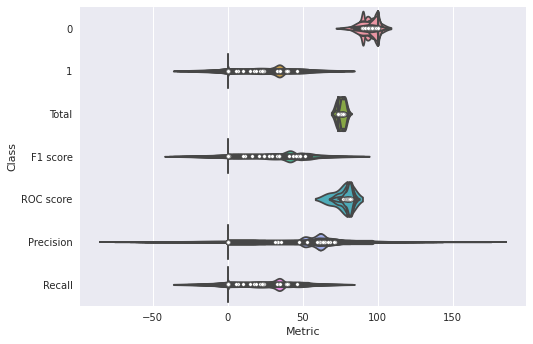

In [25]:
epochs = 100
mask_size = 10
masks_no = 80
data_size = 100
results = defaultdict(dict)


def objective(params):
    epochs = params['epochs']
    masks_no = params['masks_no']
    mask_size = params['mask_size']
    target_size = params['target_size']
    print("Training...")
    nn_results = test_model(network_pca_fn(epochs, masks_no, mask_size, target_size),
                    (X, y),
                    data_size,
                    None, 4)
    with open("sonar_params.txt", "a") as f:
        f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]) + "\n")
    return nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]

from pyhopper.callbacks import History
search = pyhopper.Search(
    {
        "epochs": pyhopper.int(50, 150, multiple_of=10),
        "masks_no": pyhopper.int(20, 100, multiple_of=10),
        "mask_size": pyhopper.int(2, 8),
        "target_size": pyhopper.choice([10, 20, 50, 100]),
    }
)

# An run the optimization for 60 minutes
best_params = search.run(objective, "maximize", "2h", n_jobs=1, seeding_ratio=0.5)

In [26]:
best_params

{'epochs': 100, 'masks_no': 20, 'mask_size': 2, 'target_size': 100}

torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.45it/s]
/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.03it/s]


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23it/s]


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.53it/s]


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.58it/s]
/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.56it/s]


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.48it/s]
/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.53it/s]
/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.58it/s]
/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.51it/s]
/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


100: 79.42 ~ 1.79, (max: 81.64)
torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:17<00:00,  4.38s/it]
/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:16<00:00,  4.36s/it]
/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:26<00:00,  2.67s/it]
/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:24<00:00,  4.44s/it]
/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:18<00:00,  4.38s/it]


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:39<00:00,  2.79s/it]
/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:04<00:00,  4.24s/it]
/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:21<00:00,  4.42s/it]


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:25<00:00,  4.46s/it]
/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([1, 128])
19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:26<00:00,  2.67s/it]
/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3000: 81.39 ~ 1.34, (max: 82.55)


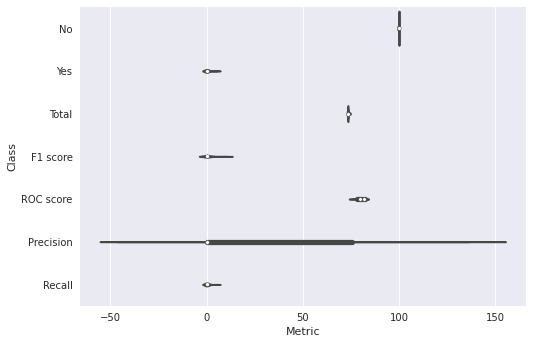

In [27]:
epochs = 100
mask_size = 2
masks_no = 20
target_size = 100
results = {}

for size in [100, 3000]:
    nn_results = test_model(network_pca_fn(epochs, masks_no, mask_size, target_size),
                    (X, y),
                    size,
                    y_label_enc, 10)
    results[size] = nn_results
    res = nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True)["Metric"]
    print(f"{size}: {res.mean():.2f} ~ {res.std():.2f}, (max: {res.max():.2f})")
    
# exp.log_table("metrics.csv", nn_results.groupby("Class").mean())
# exp.log_metric("f1_score", nn_results.groupby("Class").mean().loc["F1 score"])

In [28]:
res = nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True)["Metric"]
print(f"{3000}: {res.mean():.2f} ~ {res.std():.2f}, (max: {res.max():.2f})")

3000: 81.39 ~ 1.34, (max: 82.55)


In [60]:
nn_results = results[100]

### Hypernetwork

In [17]:
def network_fn(epochs=150, masks_no=100, mask_size=100, target_size=100):
    def _inner():
        hypernet = Hypernetwork(
                        target_architecture=[(mask_size, target_size), (target_size, 2)],
                        test_nodes=masks_no,
                        architecture=torch.nn.Sequential(torch.nn.Linear(19, 32), 
                            torch.nn.ReLU(),
                            torch.nn.Linear(32, 128),
                            torch.nn.ReLU(),
                            torch.nn.Dropout(),
                            torch.nn.Linear(128, 128),
                            torch.nn.ReLU(),
                        ),
                        mode=TrainingModes.CARTHESIAN,
                    ).to(DEVICE)    
        hypernet = hypernet.train()

        network = HypernetworkSklearnInterface(hypernet, device=DEVICE, epochs=epochs, batch_size=64)
        return network
    return _inner

In [ ]:
epochs = 100
mask_size = 10
masks_no = 80
data_size = 100
results = defaultdict(dict)


def objective(params):
    epochs = params['epochs']
    masks_no = params['masks_no']
    mask_size = params['mask_size']
    target_size = params['target_size']
    print("Training...")
    nn_results = test_model(network_fn(epochs, masks_no, mask_size, target_size),
                    (X, y),
                    data_size,
                    None, 4)
    with open("sonar_params.txt", "a") as f:
        f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]) + "\n")
    return nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]

from pyhopper.callbacks import History
search = pyhopper.Search(
    {
        "epochs": pyhopper.int(50, 150, multiple_of=10),
        "masks_no": pyhopper.int(20, 100, multiple_of=10),
        "mask_size": pyhopper.int(2, 8),
        "target_size": pyhopper.choice([10, 20, 50, 100]),
    }
)

best_params = search.run(objective, "maximize", "8h", n_jobs=2, seeding_ratio=0.5)

  0%|          | [00:00<?]

Search is scheduled for 08:00:00 (h:m:s)
Training...Training...

torch.Size([1, 128])
torch.Size([1, 128])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:34<00:00,  2.02it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 90/100 [00:40<00:04,  2.30it/s]

torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.24it/s]

 26%|████████████████████████████████▉                                                                                               | 18/70 [00:08<00:25,  2.07it/s]

torch.Size([1, 128])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:33<00:00,  2.06it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████▉                                      | 70/100 [00:30<00:13,  2.29it/s]

torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.28it/s]

 53%|███████████████████████████████████████████████████████████████████▋                                                            | 37/70 [00:17<00:15,  2.08it/s]

torch.Size([1, 128])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:34<00:00,  2.05it/s]

 48%|████████████████████████████████████████████████████████████▉                                                                  | 48/100 [00:21<00:23,  2.24it/s]/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.23it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 56/70 [00:27<00:06,  2.07it/s]

torch.Size([1, 128])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:34<00:00,  2.02it/s]

 28%|███████████████████████████████████▌                                                                                           | 28/100 [00:12<00:32,  2.21it/s]/tmp/ipykernel_2224334/1016846668.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_2224334/1016846668.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_resul

Training...
torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.60it/s]

 49%|█████████████████████████████████████████████████████████████▊                                                                 | 73/150 [01:02<01:54,  1.49s/it]/tmp/ipykernel_2224334/1016846668.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_2224334/1016846668.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_resul

Training...
torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [02:59<00:00,  1.20s/it]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 95/110 [02:11<00:23,  1.59s/it]

torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [02:31<00:00,  1.38s/it]

 15%|██████████████████▋                                                                                                            | 22/150 [00:33<03:00,  1.41s/it]

torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [01:22<00:00,  1.33it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 131/150 [02:01<00:09,  2.00it/s]

torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [02:10<00:00,  1.15it/s]

 31%|███████████████████████████████████████▎                                                                                       | 34/110 [00:15<00:34,  2.20it/s]

torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:50<00:00,  2.19it/s]

 52%|██████████████████████████████████████████████████████████████████                                                             | 78/150 [00:39<00:34,  2.07it/s]

torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:15<00:00,  1.99it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 92/110 [00:41<00:07,  2.26it/s]

torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:49<00:00,  2.23it/s]

 17%|██████████████████████                                                                                                         | 26/150 [00:12<01:00,  2.06it/s]/tmp/ipykernel_2224334/1016846668.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_2224334/1016846668.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_resul

Training...
torch.Size([1, 128])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:28<00:00,  2.78it/s]

 60%|████████████████████████████████████████████████████████████████████████████▏                                                  | 90/150 [00:44<00:30,  1.97it/s]

torch.Size([1, 128])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:28<00:00,  2.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:14<00:00,  2.02it/s]


torch.Size([1, 128])



 10%|████████████▉                                                                                                                    | 8/80 [00:02<00:25,  2.87it/s]/tmp/ipykernel_2224334/1016846668.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_2224334/1016846668.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]


Training...
torch.Size([1, 128])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:28<00:00,  2.85it/s]

 41%|████████████████████████████████████████████████████▌                                                                          | 58/140 [00:28<00:39,  2.08it/s]

torch.Size([1, 128])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:28<00:00,  2.84it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 123/140 [00:59<00:08,  2.04it/s]/tmp/ipykernel_2224334/1016846668.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_2224334/1016846668.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_resul

Training...
torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [01:08<00:00,  2.05it/s]

 22%|████████████████████████████                                                                                                   | 31/140 [00:13<00:48,  2.23it/s]/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [01:43<00:00,  1.35it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 107/140 [01:42<00:48,  1.46s/it]

torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [02:31<00:00,  1.08s/it]

 32%|████████████████████████████████████████▊                                                                                      | 45/140 [01:04<02:09,  1.36s/it]

torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [02:56<00:00,  1.26s/it]

 68%|██████████████████████████████████████████████████████████████████████████████████████▏                                        | 95/140 [01:56<00:21,  2.06it/s]

torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [02:18<00:00,  1.01it/s]

 44%|███████████████████████████████████████████████████████▎                                                                       | 61/140 [00:27<00:34,  2.28it/s]/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [01:02<00:00,  2.23it/s]

 58%|█████████████████████████████████████████████████████████████████████████▍                                                     | 81/140 [00:39<00:28,  2.05it/s]

torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [01:09<00:00,  2.02it/s]

 55%|█████████████████████████████████████████████████████████████████████▊                                                         | 77/140 [00:34<00:28,  2.24it/s]/tmp/ipykernel_2224334/1016846668.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_2224334/1016846668.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_resul

Training...
torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [01:03<00:00,  2.21it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 57/60 [00:33<00:01,  1.73it/s]/tmp/ipykernel_2224334/1016846668.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_2224334/1016846668.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_resul

Training...
torch.Size([1, 128])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:35<00:00,  1.69it/s]

 43%|███████████████████████████████████████████████████████▍                                                                        | 26/60 [00:08<00:10,  3.28it/s]

torch.Size([1, 128])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:18<00:00,  3.23it/s]

 37%|██████████████████████████████████████████████▉                                                                                 | 22/60 [00:12<00:21,  1.73it/s]

torch.Size([1, 128])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:18<00:00,  3.19it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 57/60 [00:33<00:02,  1.45it/s]


torch.Size([1, 128])

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 58/60 [00:34<00:01,  1.53it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:35<00:00,  1.69it/s]

 43%|███████████████████████████████████████████████████████▍                                                                        | 26/60 [00:08<00:10,  3.29it/s]

torch.Size([1, 128])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:18<00:00,  3.19it/s]

 37%|██████████████████████████████████████████████▉                                                                                 | 22/60 [00:12<00:22,  1.70it/s]

torch.Size([1, 128])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:18<00:00,  3.22it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 59/60 [00:34<00:00,  1.73it/s]/tmp/ipykernel_2224334/1016846668.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_2224334/1016846668.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_resul

Training...
torch.Size([1, 128])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:35<00:00,  1.70it/s]

 32%|████████████████████████████████████████▉                                                                                       | 16/50 [00:08<00:18,  1.86it/s]

torch.Size([1, 128])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.85it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████▋                                    | 43/60 [00:25<00:10,  1.64it/s]

torch.Size([1, 128])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:35<00:00,  1.70it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████▉                                              | 32/50 [00:17<00:09,  1.83it/s]/tmp/ipykernel_2224334/1016846668.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_2224334/1016846668.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_resul

Training...
torch.Size([1, 128])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.85it/s]

 35%|█████████████████████████████████████████████                                                                                  | 39/110 [00:15<00:28,  2.52it/s]

torch.Size([1, 128])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.14s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [01:15<00:00,  1.47it/s]


torch.Size([1, 128])



  4%|████▋                                                                                                                           | 4/110 [00:05<02:11,  1.24s/it]

torch.Size([1, 128])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:15<00:00,  1.52s/it]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 88/110 [01:35<00:25,  1.17s/it]/tmp/ipykernel_2224334/1016846668.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_2224334/1016846668.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_resul

Training...
torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [02:01<00:00,  1.11s/it]

 14%|█████████████████▏                                                                                                             | 19/140 [00:28<03:06,  1.54s/it]

In [53]:
res = nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True)["Metric"]
print(f"{data_size}: {res.mean():.2f} ~ {res.std():.2f}, (max: {res.max():.2f})")

3000: 82.90 ~ 0.79, (max: 84.05)


#### Hyperparameter optimizations

In [ ]:
import pyhopper

def objective(params):
    epochs = params['epochs']
    masks_no = params['masks_no']
    mask_size = params['mask_size']
    
    nn_results = test_model(network_fn(epochs, masks_no, mask_size),
                    (X, y),
                    100,
                    None, 4)
    return nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]

from pyhopper.callbacks import History
search = pyhopper.Search(
    {
        "epochs": pyhopper.int(80, 150, multiple_of=10),
        "masks_no": pyhopper.int(20, 100, multiple_of=10),
        "mask_size": pyhopper.int(2, 16),
    }
)

best_params = search.run(objective, "maximize", "6h", n_jobs=2, seeding_ratio=0.5)
with open("blastchar_search.txt", "w") as f:
    f.write(str(best_params))

  0%|          | [00:00<?]

Search is scheduled for 06:00:00 (h:m:s)
torch.Size([1, 128])
torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [02:17<00:00,  1.15s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [02:32<00:00,  1.01s/it]


torch.Size([1, 128])



  8%|█████████▌                                                                                                                      | 9/120 [00:10<02:09,  1.17s/it]

torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [02:06<00:00,  1.06s/it]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 142/150 [02:00<00:02,  2.84it/s]

torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [02:03<00:00,  1.21it/s]

 14%|█████████████████▉                                                                                                             | 17/120 [00:07<00:43,  2.35it/s]

torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:48<00:00,  2.48it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 131/150 [00:46<00:06,  2.75it/s]

torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:52<00:00,  2.84it/s]

 22%|████████████████████████████▌                                                                                                  | 27/120 [00:11<00:36,  2.52it/s]

torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:47<00:00,  2.53it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 119/150 [00:41<00:10,  2.84it/s]/tmp/ipykernel_1633640/1180352459.py:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]


torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:52<00:00,  2.86it/s]

 34%|████████████████████████████████████████████                                                                                    | 31/90 [00:15<00:29,  2.02it/s]/tmp/ipykernel_1633640/1180352459.py:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]


torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:23<00:00,  4.65it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 83/90 [00:40<00:03,  1.95it/s]

torch.Size([1, 128])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:44<00:00,  2.04it/s]

 40%|██████████████████████████████████████████████████▊                                                                            | 44/110 [00:09<00:14,  4.66it/s]

torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:23<00:00,  4.71it/s]

 36%|█████████████████████████████████████████████▌                                                                                  | 32/90 [00:15<00:29,  1.98it/s]

torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:23<00:00,  4.72it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 83/90 [00:40<00:03,  2.08it/s]

torch.Size([1, 128])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:44<00:00,  2.04it/s]

 38%|████████████████████████████████████████████████▍                                                                              | 42/110 [00:08<00:14,  4.72it/s]

torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:23<00:00,  4.70it/s]

 37%|██████████████████████████████████████████████▉                                                                                 | 33/90 [00:16<00:28,  2.02it/s]/home/MCB/wwydmanski/external/miniconda3/envs/img_processing/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_1633640/1180352459.py:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=T

torch.Size([1, 128])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:44<00:00,  2.01it/s]

 51%|█████████████████████████████████████████████████████████████████▎                                                             | 72/140 [00:35<00:32,  2.07it/s]

torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [01:08<00:00,  2.05it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 81/90 [00:40<00:04,  1.84it/s]

torch.Size([1, 128])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:50<00:00,  1.77it/s]

 15%|███████████████████                                                                                                            | 21/140 [00:29<02:52,  1.45s/it]/tmp/ipykernel_1633640/1180352459.py:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]


torch.Size([1, 128])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [02:06<00:00,  1.58s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 124/140 [02:58<00:25,  1.57s/it]

torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [03:23<00:00,  1.45s/it]

 30%|██████████████████████████████████████▍                                                                                         | 24/80 [00:42<01:41,  1.81s/it]

torch.Size([1, 128])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [01:23<00:00,  1.04s/it]

 54%|████████████████████████████████████████████████████████████████████▉                                                          | 76/140 [00:47<00:31,  2.06it/s]

torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [01:19<00:00,  1.76it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 71/80 [00:38<00:04,  1.84it/s]

torch.Size([1, 128])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:43<00:00,  1.85it/s]

 18%|██████████████████████▋                                                                                                        | 25/140 [00:12<00:57,  2.01it/s]

torch.Size([1, 128])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:43<00:00,  1.83it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 129/140 [01:04<00:05,  1.99it/s]/tmp/ipykernel_1633640/1180352459.py:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]


torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [01:09<00:00,  2.00it/s]

 28%|████████████████████████████████████▏                                                                                          | 37/130 [00:11<00:29,  3.11it/s]/tmp/ipykernel_1633640/1180352459.py:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]


torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [00:40<00:00,  3.24it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▏                                                | 80/130 [00:31<00:20,  2.45it/s]

torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [00:51<00:00,  2.50it/s]

 61%|█████████████████████████████████████████████████████████████████████████████▏                                                 | 79/130 [00:24<00:15,  3.24it/s]

torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [00:40<00:00,  3.18it/s]

 37%|██████████████████████████████████████████████▉                                                                                | 48/130 [00:19<00:33,  2.47it/s]

torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [00:51<00:00,  2.51it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 121/130 [00:36<00:02,  3.29it/s]

torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [00:39<00:00,  3.28it/s]

 12%|██████████████▋                                                                                                                | 15/130 [00:06<00:46,  2.47it/s]

torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [00:40<00:00,  3.25it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 125/130 [00:50<00:02,  2.21it/s]/tmp/ipykernel_1633640/1180352459.py:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]


torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [00:52<00:00,  2.49it/s]

 15%|███████████████████▌                                                                                                           | 20/130 [00:13<01:49,  1.01it/s]

torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [01:51<00:00,  1.17it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████▊                                    | 93/130 [01:46<00:37,  1.02s/it]

torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [02:27<00:00,  1.13s/it]

 48%|████████████████████████████████████████████████████████████▌                                                                  | 62/130 [00:55<01:04,  1.06it/s]/tmp/ipykernel_1633640/1180352459.py:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]


torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [01:55<00:00,  1.13it/s]

 47%|███████████████████████████████████████████████████████████▎                                                                   | 70/150 [01:02<00:27,  2.87it/s]

torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:30<00:00,  1.66it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 104/130 [00:31<00:07,  3.31it/s]

torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [00:39<00:00,  3.29it/s]

 21%|███████████████████████████                                                                                                    | 32/150 [00:11<00:41,  2.87it/s]

torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [00:40<00:00,  3.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:53<00:00,  2.80it/s]
/tmp/ipykernel_1633640/1180352459.py:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return nn_results[nn_results["Class"]=="ROC score"].reset_index(drop=True).mean().values[0]


torch.Size([1, 128])



  4%|█████▎                                                                                                                          | 5/120 [00:02<01:01,  1.86it/s]

torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:52<00:00,  2.86it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 112/120 [00:59<00:04,  1.74it/s]

torch.Size([1, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [01:04<00:00,  1.86it/s]

 20%|█████████████████████████▍                                                                                                     | 30/150 [00:11<00:42,  2.81it/s]

### TabNet

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor

In [149]:
np.array(X_train).shape

(134, 19)

Device used : cuda
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.84536 |  0:00:00s
epoch 1  | loss: 0.70384 |  0:00:00s
epoch 2  | loss: 0.62857 |  0:00:00s
epoch 3  | loss: 0.5942  |  0:00:00s
epoch 4  | loss: 0.59312 |  0:00:00s
epoch 5  | loss: 0.54083 |  0:00:00s
epoch 6  | loss: 0.52085 |  0:00:00s
epoch 7  | loss: 0.50849 |  0:00:00s
epoch 8  | loss: 0.50789 |  0:00:00s
epoch 9  | loss: 0.47963 |  0:00:00s
epoch 10 | loss: 0.4389  |  0:00:00s
epoch 11 | loss: 0.43232 |  0:00:00s
epoch 12 | loss: 0.40346 |  0:00:00s
epoch 13 | loss: 0.3868  |  0:00:00s
epoch 14 | loss: 0.40405 |  0:00:00s
epoch 15 | loss: 0.39284 |  0:00:00s
epoch 16 | loss: 0.39727 |  0:00:00s
epoch 17 | loss: 0.36165 |  0:00:00s
epoch 18 | loss: 0.38959 |  0:00:00s
epoch 19 | loss: 0.40563 |  0:00:00s
epoch 20 | loss: 0.40416 |  0:00:00s
epoch 21 | loss: 0.31999 |  0:00:00s
epoch 22 | loss: 0.3385  |  0:00:00s
epoch 23 | loss: 0.32313 |  0:00:00s
epoch 24 | loss: 0.3

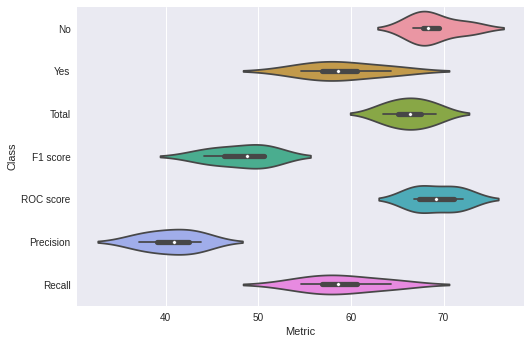

In [150]:
def tabnet_fn():
    clf = TabNetClassifier(seed=np.random.randint(1024))
    return clf

tabnet_results = test_model(tabnet_fn,
                    (np.array(X_train), np.array(y_train)), 
                    (X_test, y_test),
                    y_label_enc, 4)

In [151]:
print_statistics(tabnet_results)

F1: 48.135 ~ 3.153
C-statistics: 69.298 ~ 2.537
Precision: 40.670 ~ 2.924
Recall: 59.028 ~ 4.102


/tmp/ipykernel_276146/3812846823.py:66: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean, std = dframe[dframe["Class"]=="F1 score"].mean(), dframe[dframe["Class"]=="F1 score"].std()
/tmp/ipykernel_276146/3812846823.py:69: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean, std = dframe[dframe["Class"]=="ROC score"].mean(), dframe[dframe["Class"]=="ROC score"].std()
/tmp/ipykernel_276146/3812846823.py:72: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean, std = dframe[dframe["Class"]